## Hand-written Furigana Classification

A convolutional neural network (CNN) based model is built to classify japanese characters, i.e. Furigana. Furigana consists of Hiragana (Hi.) for normal use , and Katakana (Ka.) for foreign words or enphasis purpose. The model is trained to run Android on-device hand-written input classification powered by TensorFlow lite.

### The work includes
- extremely simple image noise clean and signal enhancement
- augmentation generates variation of original sample to increase field accurary
- 4 layered CNN model can reach validation accuracy ~98%

### Data Source:
All training sample are from [ETL Character Database](http://etlcdb.db.aist.go.jp/). The site collects multiple database from ETL1 to ETL9 with various contents, source, and format. This work uses ETL6 (Katakana) and ETL7 (Hiragana) databases. All data should retrieve from the site and cannot be commercial use without officient agreement.

### Reference:
[colab digit_classifier](https://colab.research.google.com/github/tensorflow/examples/blob/master/lite/codelabs/digit_classifier/ml/step2_train_ml_model.ipynb)

[colab digit_classifier enhancement](https://colab.research.google.com/github/tensorflow/examples/blob/master/lite/codelabs/digit_classifier/ml/step7_improve_accuracy.ipynb)

## Import

In [35]:
# direct import ETL provide sample reading script
# can be get from http://etlcdb.db.aist.go.jp/file-formats-and-sample-unpacking-code
from unpack.unpack import *

# python built-in module
import math
import random
import gc

# predefined map class provides table to encode characters to index and vise versa
from encoder_table import decoding_map, encoding_map

# third-party modules for visual and data preparation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Tensorflow and Keras for deep learning
import tensorflow as tf
from tensorflow import keras

#to solve th error, ref: https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [36]:
tf.__version__

'2.3.0'

## Setting

In [37]:
FILE_INPUT_PATH = ".\input"
MODEL_OUPUT_PATH = ".\model"
OUTPUT_MODEL_NAME = "\model.tflite"

In [38]:
# hiragana and katakata share the same process with different input
isHiraganaTraining = False

In [39]:
if isHiraganaTraining:
    # Hiragana Training setting
    LABEL_PREFIX = "Hi."
    FILE_NAME_PREFIX = "\ETL7LC_"
    START_FILE_SERIAL_NO = 1
    END_FILE_SERIAL_NO = 2
    NUM_CLASSES = 46
else:
    # Katakana Training setting
    LABEL_PREFIX = "Ka."
    FILE_NAME_PREFIX = "\ETL6C_"
    START_FILE_SERIAL_NO = 1
    END_FILE_SERIAL_NO = 5
    NUM_CLASSES = 46

## Data Reading

In [40]:
def readRawData(filename, label_prefix):
    
    # img width and height related to input tensor shape, so will be preserved globally
    global img_width
    global img_height

    if label_prefix not in ("Hi.", "Ka."):
        print("Prefix should be either Hi. or Ka. in order to match encoding table")
        return;
    
    f = bitstring.ConstBitStream(filename=filename)
    etln_record = ETL167_Record() #set reader for ETL 1, 6, 7 format

    labels = None
    images = None
    tmp_labels = []
    tmp_img = []

    while f.pos < f.length:

        # read BitStream into a formated map
        record = etln_record.read(f)

        # get labels
        label = record["Character Code"].strip(" ")
        if ("," in label) or (")"  in label) or ("("  in label):
            # skip symbols in ETL6
            # skip Dakuten, Handakuten marks for ETL7
            continue 
        tmp_labels.append(label)

        # get images in numpy array
        img = etln_record.get_image()
       
        img_width = img.size[0]
        img_height = img.size[1]
        img_array = np.array(img).reshape(1, img_height, img_width) #reshape into 3d for concatenating

        tmp_img.append(img_array)

    images = np.concatenate(tmp_img)
    labels = np.array(tmp_labels)
    
    return images, labels

In [41]:
tmp_images_list = []
tmp_labels_list = []

for i in range(START_FILE_SERIAL_NO, END_FILE_SERIAL_NO + 1):

    if isHiraganaTraining:
        file_serial_number = f"{i}" #ETL7LC_1 without padding zero
    else:
        file_serial_number = f"{i:02}" #ETL6C_01 with padding zero
        
    file_name = FILE_INPUT_PATH + FILE_NAME_PREFIX + file_serial_number
    
    tmp_images, tmp_labels = readRawData(file_name, LABEL_PREFIX)
    
    tmp_images_list.append(tmp_images)
    tmp_labels_list.append(tmp_labels)

In [42]:
# wrap data from different file into one as numpy array
images = np.concatenate(tmp_images_list, axis=0)
labels = np.concatenate(tmp_labels_list, axis=0)

In [43]:
del tmp_images_list
del tmp_labels_list
gc.collect()

2793

In [44]:
# each image with size 64x63 px(w x h). The sample should be read as (#sample, height, width)
print(images.shape)
print(labels.shape)

(63618, 63, 64)
(63618,)


## Preprocessing

In [45]:
# draw images from serialized data with their label

def show_sample(images, labels, sample_count=25, rand=False):
  grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
  grid_count = min(grid_count, len(images), len(labels))
  
  plt.figure(figsize=(2*grid_count, 2*grid_count))
  for i in range(sample_count):
    if rand:
        # random iamges
        rand_idx = random.randint(0, images.shape[0])
        image = images[rand_idx]
        label = labels[rand_idx]
    else:
        image = images[i]
        label = labels[i]
    
    plt.subplot(grid_count, grid_count, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.xlabel(label)
  plt.show()

In [46]:
# Tensorflow needs labels in integer format
def encode(labels, encoding_map):
    encoded = []
    for label in labels:
        encoded.append(encoding_map[label])
    return np.array(encoded)

Each px is saved in 4bit, 16 types gray scale intensity.
This process filter lower intensity to supress background noise, and enhance higher intensity to make it clear aclose to on-device situation.

In [47]:
def preprocess(raw_images):
    noise_filter_threshold = 130;
    contrast_enhancement_threshold = 150
    
    raw_images[raw_images<noise_filter_threshold] = 0 # supressed surrounding noise
    raw_images[raw_images>contrast_enhancement_threshold] = 255 # make withe stroke brighter
    
    raw_images = raw_images / 255.0 # scaled value from 0~255 to 0~1

    return raw_images

In [48]:
X = preprocess(images)
y = encode(labels, encoding_map) #label need to be integer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

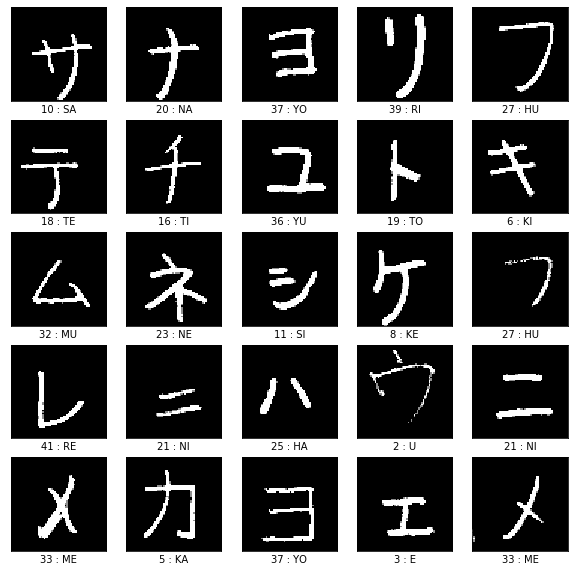

In [49]:
show_sample(X_train, [f"{label} : {decoding_map[label]}" for label in y_train], 25, rand = True)

## Augmentation
Apply rotaion, shift, distortion, resizing, etc. to create variations from original database to make it more robust for real inputs.

In [50]:
datagen = keras.preprocessing.image.ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.15,
  height_shift_range=0.15,
  shear_range=0.35,
  zoom_range=0.2
)

# ImageDataGenerator takes 3D input for each image -> expand from (63, 64) -> (63, 64, 1)
train_generator = datagen.flow(np.expand_dims(X_train,axis=3), y_train)
test_generator = datagen.flow(np.expand_dims(X_test,axis=3), y_test)

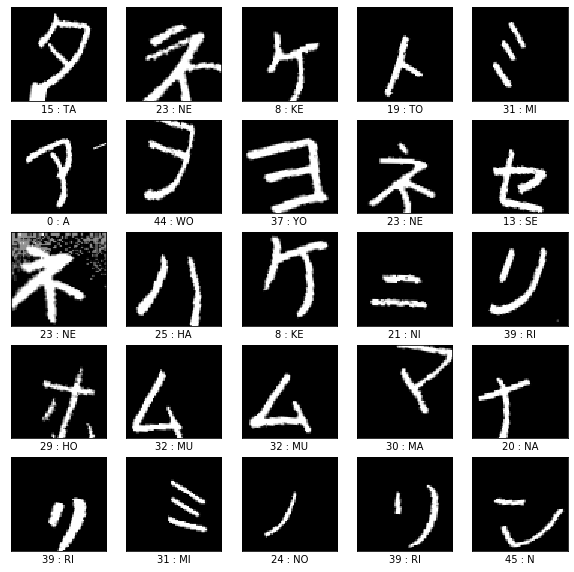

In [51]:
# Images after augmentation
argumented_X_train, argumented_y_train = next(train_generator)
show_sample(np.squeeze(argumented_X_train, axis=3), [f"{label} : {decoding_map[label]}" for label in argumented_y_train])

## Training

In [52]:
assert img_height > 0
assert img_width > 0

Totally 4 convolution layers are used:
- Conv2D : 
    - 3x3 kernal (=filter) to create feature map from each layer
    - increasing depth (#filters) from 32 to 128 to be able to extract more abstract features at latter layers
- MaxPooling2D :
    - 2x2 matrix to down-sample the inputs to reduce dimensionality (ex. 28x28 px after pooling will be 14x14 px)
- Dropout layer
    - supress overfitting

In [53]:
# Create Model
model = keras.Sequential([
    
    keras.layers.Reshape(target_shape=(img_height, img_width, 1)),
    
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
   
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(NUM_CLASSES)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
model.fit(train_generator, epochs=200, callbacks=[callback], validation_data=test_generator)

Epoch 1/200
1332/1332 [==============================] - 31s 23ms/step - loss: 2.3850 - accuracy: 0.3387 - val_loss: 0.5521 - val_accuracy: 0.8645
Epoch 2/200
1332/1332 [==============================] - 30s 22ms/step - loss: 0.9212 - accuracy: 0.7180 - val_loss: 0.2446 - val_accuracy: 0.9385
Epoch 3/200
1332/1332 [==============================] - 30s 22ms/step - loss: 0.6286 - accuracy: 0.8066 - val_loss: 0.1772 - val_accuracy: 0.9521
Epoch 4/200
1332/1332 [==============================] - 30s 22ms/step - loss: 0.5030 - accuracy: 0.8483 - val_loss: 0.1306 - val_accuracy: 0.9633
Epoch 5/200
1332/1332 [==============================] - 30s 22ms/step - loss: 0.4282 - accuracy: 0.8722 - val_loss: 0.1252 - val_accuracy: 0.9651
Epoch 6/200
1332/1332 [==============================] - 30s 22ms/step - loss: 0.3843 - accuracy: 0.8863 - val_loss: 0.1146 - val_accuracy: 0.9680
Epoch 7/200
1332/1332 [==============================] - 30s 22ms/step - loss: 0.3454 - accuracy: 0.8983 - val_loss: 0

1332/1332 [==============================] - 30s 22ms/step - loss: 0.1853 - accuracy: 0.9503 - val_loss: 0.0626 - val_accuracy: 0.9826
Epoch 57/200
1332/1332 [==============================] - 30s 22ms/step - loss: 0.1820 - accuracy: 0.9512 - val_loss: 0.0630 - val_accuracy: 0.9835
Epoch 58/200
1332/1332 [==============================] - 30s 22ms/step - loss: 0.1931 - accuracy: 0.9474 - val_loss: 0.0667 - val_accuracy: 0.9822
Epoch 59/200
1332/1332 [==============================] - 30s 22ms/step - loss: 0.1780 - accuracy: 0.9511 - val_loss: 0.0599 - val_accuracy: 0.9835
Epoch 60/200
1332/1332 [==============================] - 30s 22ms/step - loss: 0.1797 - accuracy: 0.9516 - val_loss: 0.0610 - val_accuracy: 0.9837
Epoch 61/200
1332/1332 [==============================] - 30s 22ms/step - loss: 0.1856 - accuracy: 0.9497 - val_loss: 0.0677 - val_accuracy: 0.9827
Epoch 62/200
1332/1332 [==============================] - 30s 22ms/step - loss: 0.1840 - accuracy: 0.9510 - val_loss: 0.0712 

## Validation

In [55]:
argumented_X_test, argumented_y_test = next(test_generator)
y_pred = model.predict(argumented_X_test)

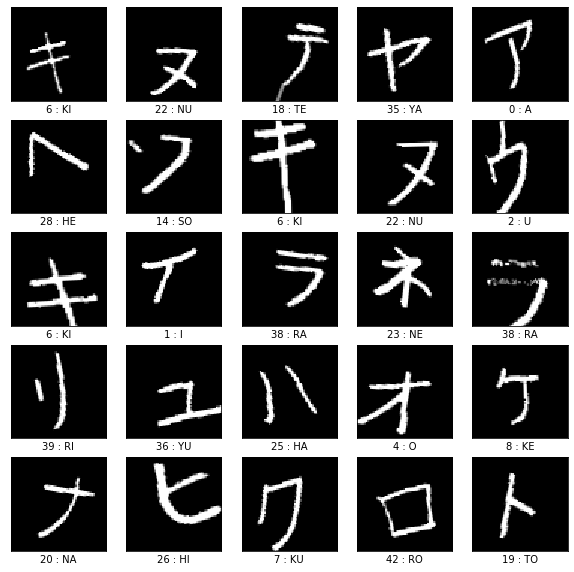

In [56]:
show_sample(np.squeeze(argumented_X_test, axis=3), [f"{np.argmax(pred)} : {decoding_map[np.argmax(pred)]}" for pred in y_pred])

In [57]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TF Lite model as file
f = open(MODEL_OUPUT_PATH + OUTPUT_MODEL_NAME, "wb")
f.write(tflite_model)
f.close()

INFO:tensorflow:Assets written to: C:\Users\Monster\AppData\Local\Temp\tmp8q_8peh0\assets


INFO:tensorflow:Assets written to: C:\Users\Monster\AppData\Local\Temp\tmp8q_8peh0\assets
